gotta get those dependencies

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import math
import fastai


from datetime import (
    datetime
)

from sklearn.preprocessing import (
    StandardScaler
)

from fastai.tabular.all import (
    LinBnDrop
)

from fastai.layers import (
    Identity
)

from fastai.metrics import (
    BalancedAccuracy,
    F1Score,
    MatthewsCorrCoef,
    Precision,
    Recall,
    RocAuc
)

from typing import (
    Callable,
    Dict,
    List,
    Tuple
)

from Quick.cleaning.loading import (
    examine_dataset,
    remove_infs_and_nans
)

from Quick.cleaning.utils import (
    get_file_path
)

from Quick.runners.deep import (
    run_deep_nn_experiment
)

from Quick.runners.residual import (
    run_residual_deep_nn_experiment
)

from Quick.runners.sk import (
    run_sk_experiment
)

from Quick.runners.torch import (
    run_torch_nn_experiment
)

from rff.layers import (
    GaussianEncoding,
)

from Quick.constants import *

download the dataset from this link --> https://www.unb.ca/cic/datasets/tor.html

this is the paper --> https://www.scitepress.org/PublishedPapers/2017/61056/61056.pdf

In [10]:
scenario_a = '../data/Tor/CSV/Scenario-A/tor-nontor.csv' # labeled tor and non-tor 
scenario_b = '../data/Tor/CSV/Scenario-B/app_type.csv' # labeled (Browsing, Audio, CHAT, Mail, P2P, FT, VOIP, and Video)

In [11]:
scenario = input("a or b: ")

if scenario == 'a':
    dataset = pd.read_csv(scenario_a)
    print('scenario a selected')
elif scenario == 'b':
    dataset = pd.read_csv(scenario_b)
    print('scenario b selected')
else:
    print('scenario selection failed')



scenario a selected


preproccesing...

In [12]:
dataset

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,10.0.2.15,53913,216.58.208.46,80,6,435,0.0,4597.701149,435.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
1,10.0.2.15,53913,216.58.208.46,80,6,259,0.0,7722.007722,259.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
2,10.0.2.15,53913,216.58.208.46,80,6,891,0.0,2244.668911,891.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
3,10.0.2.15,53913,216.58.208.46,80,6,1074,0.0,1862.197393,1074.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
4,10.0.2.15,53913,216.58.208.46,80,6,315,0.0,6349.206349,315.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67829,131.202.240.183,7116,239.255.255.250,1900,17,0,inf,inf,0.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
67830,131.202.240.183,7116,239.255.255.250,1900,17,0,inf,inf,0.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
67831,131.202.240.87,11365,31.13.73.1,443,6,0,inf,inf,0.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
67832,131.202.6.26,13000,131.202.240.87,64584,6,0,NaN,inf,0.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR


In [13]:
dataset['label'].value_counts()

label
nonTOR    59790
TOR        8044
Name: count, dtype: int64

In [14]:
# no need for either of these

# one hot encode
# one_hot_encoded = pd.get_dummies(dataset['label'], prefix='label')
# dataset = pd.concat([dataset, one_hot_encoded], axis=1)
# dataset.drop('label', axis=1, inplace=True) # drop og
# dataset

# label encode 
# le = LabelEncoder()
# dataset['label'] = le.fit_transform(dataset['label'])
# dataset.head()

In [15]:
# drop na's
dataset.dropna(inplace=True)

create train and test data

In [16]:
# get rid of the spaces (dataset spacing is wack)
dataset.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
dataset.columns

Index(['Source_IP', '_Source_Port', '_Destination_IP', '_Destination_Port',
       '_Protocol', '_Flow_Duration', '_Flow_Bytes/s', '_Flow_Packets/s',
       '_Flow_IAT_Mean', '_Flow_IAT_Std', '_Flow_IAT_Max', '_Flow_IAT_Min',
       'Fwd_IAT_Mean', '_Fwd_IAT_Std', '_Fwd_IAT_Max', '_Fwd_IAT_Min',
       'Bwd_IAT_Mean', '_Bwd_IAT_Std', '_Bwd_IAT_Max', '_Bwd_IAT_Min',
       'Active_Mean', '_Active_Std', '_Active_Max', '_Active_Min', 'Idle_Mean',
       '_Idle_Std', '_Idle_Max', '_Idle_Min', 'label'],
      dtype='object')

scenario a

Index(['Source_IP', '_Source_Port', '_Destination_IP', '_Destination_Port',
       '_Protocol', '_Flow_Duration', '_Flow_Bytes/s', '_Flow_Packets/s',
       '_Flow_IAT_Mean', '_Flow_IAT_Std', '_Flow_IAT_Max', '_Flow_IAT_Min',
       'Fwd_IAT_Mean', '_Fwd_IAT_Std', '_Fwd_IAT_Max', '_Fwd_IAT_Min',
       'Bwd_IAT_Mean', '_Bwd_IAT_Std', '_Bwd_IAT_Max', '_Bwd_IAT_Min',
       'Active_Mean', '_Active_Std', '_Active_Max', '_Active_Min', 'Idle_Mean',
       '_Idle_Std', '_Idle_Max', '_Idle_Min', 'label'],
      dtype='object')

scenario b

Index(['Source_IP', '_Source_Port', '_Destination_IP', '_Destination_Port',
       '_Protocol', '_Flow_Duration', '_Flow_Bytes/s', '_Flow_Packets/s',
       '_Flow_IAT_Mean', '_Flow_IAT_Std', '_Flow_IAT_Max', '_Flow_IAT_Min',
       'Fwd_IAT_Mean', '_Fwd_IAT_Std', '_Fwd_IAT_Max', '_Fwd_IAT_Min',
       'Bwd_IAT_Mean', '_Bwd_IAT_Std', '_Bwd_IAT_Max', '_Bwd_IAT_Min',
       'Active_Mean', '_Active_Std', '_Active_Max', '_Active_Min', 'Idle_Mean',
       '_Idle_Std', '_Idle_Max', '_Idle_Min', 'label'],
      dtype='object')


In [17]:
source_columns = [
    'Source_IP', '_Source_Port',
]

destination_columns = [
    '_Destination_IP', '_Destination_Port',
]

flow_columns = [
   '_Flow_Duration', '_Flow_Bytes/s', '_Flow_Packets/s',
]

flow_iat_columns = [
    '_Flow_IAT_Mean', '_Flow_IAT_Std', '_Flow_IAT_Max', '_Flow_IAT_Min',
]

fwd_iat_columns = [
    'Fwd_IAT_Mean', '_Fwd_IAT_Std', '_Fwd_IAT_Max', '_Fwd_IAT_Min',
]

bwd_iat_columns = [
   'Bwd_IAT_Mean', '_Bwd_IAT_Std', '_Bwd_IAT_Max', '_Bwd_IAT_Min',
]

active_columns = [
    'Active_Mean', '_Active_Std', '_Active_Max', '_Active_Min', 
]

idle_columns = [
    'Idle_Mean', '_Idle_Std', '_Idle_Max', '_Idle_Min',
]

label_columns = [
    'label',
]

feature_groups = {
    'flow_iat': flow_iat_columns,
    'flow': flow_columns,
    'bwd_iat': bwd_iat_columns,
    'idle': idle_columns,
}

features = []


In [18]:

for group in feature_groups.values():
    features.extend(group)

columns = features + label_columns

# we reorder the columns
df = dataset[columns]


In [19]:
class MultiheadAttention(nn.Module):
    def __init__(
        self,
        embedding_size     : int,
        heads              : int,
        device             : torch.device,
    ) -> None:
    
        super(MultiheadAttention, self).__init__()

        self.embedding_size      = embedding_size
        self.heads               = heads

        if embedding_size % heads != 0:
            raise Exception(f'embedding_size must be divisible by heads. embedding_size: {embedding_size}, heads: {heads}')

        self.query = nn.Linear(embedding_size, embedding_size, device = device)
        self.key   = nn.Linear(embedding_size, embedding_size, device = device)
        self.value = nn.Linear(embedding_size, embedding_size, device = device)

        # The constant that is used to scale the dot product, we precompute it for efficiency
        self.scaling_denominator = torch.tensor(
            math.sqrt(embedding_size // heads), 
            dtype=torch.float32, 
            device=device
        )

        self.softmax = nn.Softmax(dim=-1)

    def forward(
        self, 
        q: torch.Tensor, 
        v: torch.Tensor,
        k: torch.Tensor
    ):
        '''
            We perform multihead attention on the query embeddings using the encoder state as the key and value

            shape:
                x: (batch_size, total_num_queries, embedding_size)
                encoder_state: (batch_size, lookback_size, embedding_size)
                output: (batch_size, total_num_queries, embedding_size)
        '''

        # print(f"q: {q.shape}")

        key  : torch.Tensor = self.key(k)
        value: torch.Tensor = self.value(v)
        query: torch.Tensor = self.query(q)

        # we split the query, key, and value into heads
        query = query.reshape(
            query.shape[0],
            query.shape[1],
            self.heads,
            self.embedding_size // self.heads
        ).transpose(1, 2)

        key = key.reshape(
            key.shape[0],
            key.shape[1],
            self.heads,
            self.embedding_size // self.heads
        ).transpose(1, 2)

        value = value.reshape(
            value.shape[0],
            value.shape[1],
            self.heads,
            self.embedding_size // self.heads
        ).transpose(1, 2)

        # we perform the attention
        pre_attention = torch.matmul(query, key.transpose(-2, -1))/self.scaling_denominator

        # print(f"pre_attention: {pre_attention.shape}")

        # we apply the softmax to the pre_attention
        distribution = self.softmax(pre_attention)


        # print(f"distribution: {distribution.shape}")
        # print(f"value: {value.shape}")

        # we multiply the distribution by the value to give the attention output
        attention = torch.einsum('bhqk,bhkd->bhqd', distribution, value)

        # print(f"attention: {attention.shape}")


        # Finally, we reshape the attention, transitioning between the following shapes:
        #       attention shape: batch_size, heads, total_num_queries, embedding_size // heads
        #       final shape: batch_size, total_num_queries, embedding_size
        full_attention = attention.transpose(1, 2).reshape(
            attention.shape[0],
            attention.shape[-2],
            self.embedding_size
        )

        # print(f"full_attention: {full_attention.shape}")

        return full_attention


In [20]:
class Encoder(nn.Module):
    def __init__(
        self,
        embedding_size     : int,
        heads              : int,
        device             : torch.device,
        forward_expansion  : int      = 4,
        dropout            : float    = 0.0,
        pre_norm           : bool     = False,
        activation = nn.ReLU(),
    ) -> None:
    
        super(Encoder, self).__init__()

        self.embedding_size     = embedding_size
        self.heads              = heads
        self.forward_expansion  = forward_expansion
        self.dropout            = dropout
        self.activation         = activation
        self.pre_norm           = pre_norm

        self.attention = MultiheadAttention(embedding_size, heads, device)

        self.norm_1 = nn.LayerNorm(embedding_size)
        self.norm_2 = nn.LayerNorm(embedding_size)

        self.hidden_size = int(embedding_size * forward_expansion)

        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_size, self.hidden_size),
            self.activation,
            nn.Linear(self.hidden_size, embedding_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        x: torch.Tensor,
    ) -> torch.Tensor:
        '''
            We perform multihead attention. 
            
            If we prenorm, we apply layer norm before the attention and feed forward layers,
                otherwise we apply it after 
        '''

        # print(f"x: {x.shape}")

        if self.pre_norm:
            x_hat = self.norm_1(x)
            attention = self.attention(x_hat, x_hat, x_hat)
            x_hat = x + self.dropout(attention)
        else: 
            attention = self.attention(x, x, x)
            x_hat = self.norm_1(x + self.dropout(attention))


        if self.pre_norm:
            x_hat = self.norm_2(x_hat)
            feed_forward = self.feed_forward(x_hat)
            x_hat = x_hat + self.dropout(feed_forward)
        else:
            feed_forward = self.feed_forward(x_hat)
            x_hat = self.norm_2(x_hat + self.dropout(feed_forward))

        return x_hat


In [21]:
class GroupEmbedding(nn.Module):

    def __init__(
        self,
        embedding_size: int,
        input_size: int,
        use_rff: bool,
        device: torch.device,
        rff_dim: int = 64,
        rff_std: float = 2.5,
        learnable_rff_std: bool = False,
        activation: nn.Module = nn.ReLU(),
    ) -> None:
        super(GroupEmbedding, self).__init__()

        self.embedding_size = embedding_size
        self.device = device
        self.use_rff = use_rff
        self.rff_dim = rff_dim
        self.rff_std = rff_std
        self.learnable_rff_std = learnable_rff_std


        if use_rff:
            self.rff = GaussianEncoding(
                rff_std,
                input_size,
                rff_dim
            ).to(device)

        if learnable_rff_std:
            self.std_vec = nn.Parameter(torch.ones(input_size, device=device))
            
        
        self.linear_size = input_size + 2*self.rff_dim if use_rff else input_size

        self.linear = nn.Linear(
            self.linear_size,
            embedding_size, 
            device=device
        )

        self.activation = activation

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
            We embed the input using the strategy found suggested in the following papers: 
                Time2Vec: Learning a Vector Representation of Time: 
                    https://arxiv.org/abs/1907.05321

                On Embeddings for Numerical Features in Tabular Deep Learning: 
                    https://arxiv.org/abs/2203.05556
                    
                Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains: 
                    https://arxiv.org/abs/2006.10739
        
            We first pass the the input through an encoding layer, which is either an RFF layer or nothing.
            If there is an encoding layer, we concatenate the encoding with the input.
            Then, we pass the output of the encoding layer through a linear layer and an activation function.
        '''

        if self.use_rff:
            if self.learnable_rff_std:
                x = x * self.std_vec

            rff = self.rff(x)
            # print(f"rff: {rff.shape}")
            # print(f"x: {x.shape}")
            x = torch.cat((x, rff), dim=-1)

        # print(f'post rff x shape: {x.shape}')
        # print(f"self.linear_size: {self.linear_size}")

        x = self.linear(x)
        x = self.activation(x)

        return x

        

In [22]:
class DebugLayer(nn.Module):
    def __init__(
        self,
        verbose: bool = False,
        message: str = '',
    ) -> None:
        super(DebugLayer, self).__init__()
        self.verbose = verbose
        self.message = message

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.verbose:
            print(f"{self.message}: {x.shape}")
            self.verbose = False
            
        return x



In [23]:
class FlowTransformer(nn.Module):

    def __init__(
        self, 
        input_features = 62, 
        output_features = 8, 
        device = torch.device('cpu'), 
        config: dict = {
            'feature_groups': feature_groups,
            'activation': nn.ReLU(),
            'verbose': True,
            'embeddings': {
                'embedding_size': 64,
                'use_rff': True,
                'rff_dim': 64,
                'rff_std': 2.5,
                'learnable_rff_std': False,
            },
            'encoder':{
                'layers': 2,
                'heads': 4,
                'forward_expansion': 2,
                'pre_norm': False,
                'dropout': 0.0,
            },
            'aggregation': {
                'type': 'LSTM',
                'layers': 1,
            },
            'classification_head': {
                'layers': 2,
                'hidden_size': 64,
                'batch_norm': False,
                'activation': nn.ReLU(),
            }
        }
    ):
        '''
            This will be a transformer that takes feature groups and transforms them into
                embedding vectors. The embedding vectors will pass through a series of
                encoder layers and then will be aggregated into a single vector. This vector
                will then be passed into a classification head.

            We will be using this in conjunction with a test harness in the quick library.
                Every model that is used in this manner will need to have the 4 init parameters:
                    # of input features
                    # of output features
                    device
                    a config dictionary

            The config dictionary will be used to specify the architecture of the model, and 
                even when not using a config, one must be passed through the test harness in order
                to work correctly.
            
        '''

        super(FlowTransformer, self).__init__()

        self.input_features = input_features
        self.output_features = output_features
        self.device = device
        self.config = config
        self.verbose = config['verbose']

        print(f'input features: {self.input_features}')
        print(f'output features: {self.output_features}')

        # First, we create our embeddings for each feature group

        self.feature_groups = config['feature_groups']
        self.embedding_size = config['embeddings']['embedding_size']

        self.use_rff = config['embeddings']['use_rff']
        self.rff_dim = config['embeddings']['rff_dim']
        self.rff_std = config['embeddings']['rff_std']
        self.learnable_rff_std = config['embeddings']['learnable_rff_std']

        self.activation = config['activation']



        self.embeddings = nn.ModuleDict()

        for group, columns in self.feature_groups.items():
            self.embeddings[group] = GroupEmbedding(
                config['embeddings']['embedding_size'],
                len(columns),
                self.use_rff,
                device,
                self.rff_dim,
                self.rff_std,
                self.learnable_rff_std,
                self.activation
            )

        # Next, we create our encoder layers

        self.encoder_layers = config['encoder']['layers']
        self.encoder_heads = config['encoder']['heads']
        self.encoder_forward_expansion = config['encoder']['forward_expansion']
        self.encoder_pre_norm = config['encoder']['pre_norm']
        self.encoder_dropout = config['encoder']['dropout']

        encoder_layers = [
            Encoder(
                self.embedding_size,
                self.encoder_heads,
                self.device,
                self.encoder_forward_expansion,
                self.encoder_dropout,
                self.encoder_pre_norm,
                self.activation
            ) for _ in range(self.encoder_layers)
        ]
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Now, we create our aggregation layer
        
        self.aggregation_type = config['aggregation']['type']
        

        # Add your own aggregation layers here
        if self.aggregation_type == 'LSTM':
            self.aggregation = nn.LSTM(
                input_size = self.embedding_size,
                hidden_size = self.embedding_size,
                num_layers = config['aggregation']['layers'],
                batch_first = True,
            ).to(device)
        else:
            raise Exception(f'aggregation type {self.aggregation_type} not supported')

    
        # Finally, we create our classification head
        self.classification_head_layers = config['classification_head']['layers']
        self.classification_head_hidden_size = config['classification_head']['hidden_size']
        self.classification_head_batch_norm = config['classification_head']['batch_norm']
        self.classification_head_activation = config['classification_head']['activation']

        self.classification_head = []
        
        for i in range(self.classification_head_layers):
                
            input_size = self.embedding_size if i == 0 else self.classification_head_hidden_size

            self.classification_head.append(
                nn.Linear(
                    input_size,
                    self.classification_head_hidden_size,
                    device = self.device
                )
            )

               
            if self.classification_head_batch_norm:
                self.classification_head.append(
                    nn.BatchNorm1d(
                        self.classification_head_hidden_size,
                        device = self.device
                    )
                )

            self.classification_head.append(
                self.classification_head_activation
            )

            if self.verbose:
                self.classification_head.append(
                    DebugLayer(
                        verbose = self.verbose, 
                        message = f"Classification Head Layer {i}"
                    )
                )

        self.classification_head.append(
            nn.Linear(
                self.classification_head_hidden_size,
                self.output_features,
                device = self.device
            )
        )

        self.classification_head = nn.Sequential(*self.classification_head)


        self.flag = config['verbose']

    def forward(self, x):

        # First, we embed the input
        embeddings = []
        current_idx = 0

        batch_size = x.shape[0]

        for group, columns in self.feature_groups.items():
            group_embedding = self.embeddings[group](x[:, current_idx:current_idx + len(columns)])
            group_embedding = group_embedding.reshape(batch_size, 1, self.embedding_size)
            embeddings.append(group_embedding)
            current_idx += len(columns)

        # Next, we concatenate the embeddings
        embedding_tensor = torch.cat(embeddings, dim=1)

        # print(f'embedding tensor shape: {embedding_tensor.shape}')

        # Then, we pass the embeddings through the encoder layers
        embeddings = self.encoder(embedding_tensor)

        # Next, we aggregate the embeddings
        if self.aggregation_type == 'LSTM':
            embeddings, _ = self.aggregation(embeddings)
            # print(f"Raw aggregation shape: {embeddings.shape}")
            embeddings = embeddings[:, -1, :].reshape(batch_size, self.embedding_size)
            # print(f"Post aggregation shape: {embeddings.shape}")

        # Finally, we pass the embeddings through the classification head
        output = self.classification_head(embeddings)


        if self.flag:
            print(f"embeddings shape: {embeddings.shape}")
            print(f"aggregated embeddings shape: {embeddings.shape}")
            print(f"output shape: {output.shape}")

            self.flag = False

        # raise Exception('stop')
        return output
    

    

In [27]:
METRICS: list = [
    accuracy,
    BalancedAccuracy(),
    # RocAuc(),
    MatthewsCorrCoef(),
    F1Score(average='macro'),
    Precision(average='macro'),
    Recall(average='macro'),
]

results_flow_transformer_1 = run_torch_nn_experiment(
    df, 
    scenario, 
    'label', 
    FlowTransformer,
    metrics=METRICS,
    lr_choice='None',
    config = {
        'feature_groups': feature_groups,
        'activation': nn.ReLU(),
        'verbose': True,
        'embeddings': {
            'embedding_size': 64,
            'use_rff': True,
            'rff_dim': 64,
            'rff_std': 2.5,
            'learnable_rff_std': False,
        },
        'encoder':{
            'layers': 2,
            'heads': 4,
            'forward_expansion': 2,
            'pre_norm': False,
            'dropout': 0.0,
        },
        'aggregation': {
            'type': 'LSTM',
            'layers': 1,
        },
        'classification_head': {
            'layers': 2,
            'hidden_size': 64,
            'batch_norm': False,
            'activation': nn.ReLU(),
        }
    }
)


model = results_flow_transformer_1.model.model.model

print(f"Learnable Parameters: \t\t\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Shape of Input Data: (67832, 16)
input features: 15
output features: 2


KeyError: 'None'

Shape of Input Data: (8044, 16)
input features: 15
output features: 8


Classification Head Layer 0: torch.Size([64, 64])
Classification Head Layer 1: torch.Size([64, 64])
embeddings shape: torch.Size([64, 128])
aggregated embeddings shape: torch.Size([64, 128])
output shape: torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.520137,1.532510,0.440920,0.227855,0.813769,0.298487,0.157630,0.180199,0.227855,00:03
1,1.400337,1.292206,0.477612,0.275460,0.811079,0.362612,0.219360,0.241382,0.275460,00:04
2,1.442418,1.550345,0.442786,0.227923,0.751533,0.307890,0.146987,0.108739,0.227923,00:04
3,1.389784,1.632871,0.436567,0.224689,0.797970,0.290324,0.156408,0.145818,0.224689,00:04
4,1.444075,1.502799,0.453358,0.235633,0.742869,0.329612,0.151333,0.112670,0.235633,00:03
5,1.405172,1.272948,0.537935,0.313758,0.804773,0.441559,0.247406,0.224728,0.313758,00:03
6,1.266728,1.259661,0.539801,0.314588,0.827574,0.448435,0.248777,0.262077,0.314588,00:03
7,1.218075,1.272497,0.545398,0.321707,0.829411,0.452052,0.264384,0.301794,0.321707,00:03
8,1.193898,1.224192,0.547886,0.325355,0.839188,0.452036,0.272961,0.293499,0.325355,00:03
9,1.175523,1.232729,0.551617,0.330732,0.837961,0.457612,0.283214,0.313193,0.330732,00:03


c:\Users\prime\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


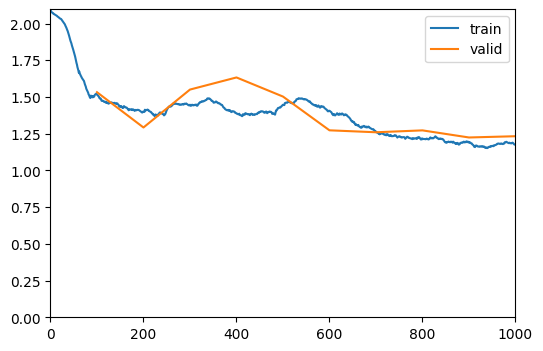

c:\Users\prime\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\prime\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\prime\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\prime\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_cl

c:\Users\prime\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\prime\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\prime\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 1.2327293157577515, accuracy:  55.16%


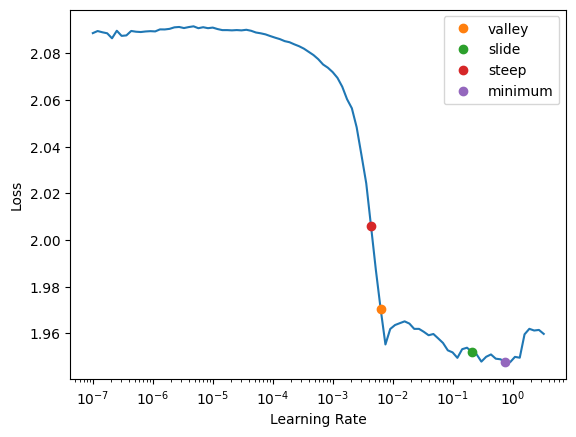

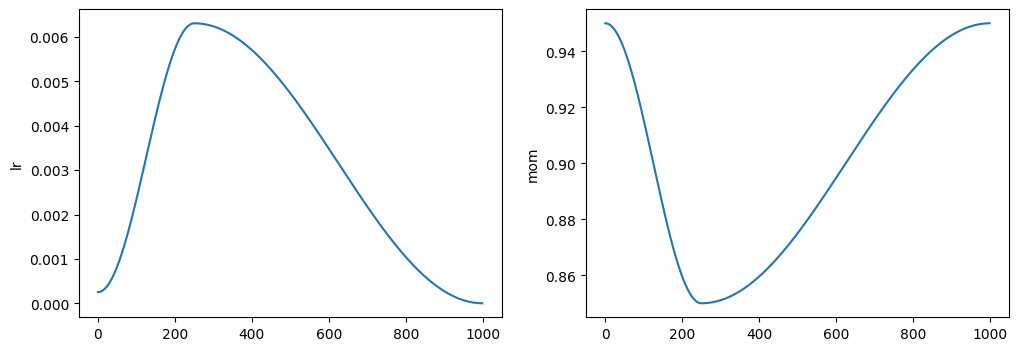

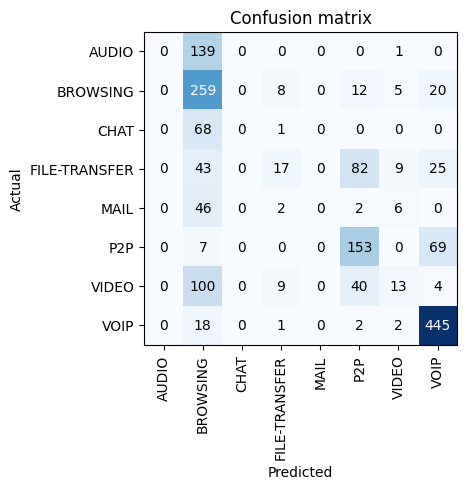

In [ ]:
results_flow_transformer_1 = run_torch_nn_experiment(
    df, 
    scenario, 
    'label', 
    FlowTransformer, 
    config = {
        'feature_groups': feature_groups,
        'activation': nn.ReLU(),
        'verbose': True,
        'embeddings': {
            'embedding_size': 128,
            'use_rff': True,
            'rff_dim': 128,
            'rff_std': .5,
            'learnable_rff_std': True,
        },
        'encoder':{
            'layers': 2,
            'heads': 4,
            'forward_expansion': 2,
            'pre_norm': False,
            'dropout': 0.0,
        },
        'aggregation': {
            'type': 'LSTM',
            'layers': 1,
        },
        'classification_head': {
            'layers': 2,
            'hidden_size': 64,
            'batch_norm': False,
            'activation': nn.ReLU(),
        }
    }
)